# importing acl-anthology bib file & creating csv

In [1]:
import requests
import gzip
import shutil
import os
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import pylab
import colorcet as cc
import pprint

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/nell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [ ]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [ ]:
import pandas as pd
import sre_yield

df = pd.DataFrame()

keywords = ['bias', 'fairness', 'protected category', 'stereotype', 'social group signal']

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            temp_row = {}

            # select only select papers from 2016 on
            if 'year' in paper.keys() and int(paper['year']) >= 2016:

                for cat in paper.keys():
                    temp_row[cat] = paper[cat]

                df = pd.concat([df, pd.DataFrame([temp_row])], ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [ ]:
print(len(df))

# Import existing csv
Leave this out if you ran the parts above

In [2]:
# uncomment if csv is already in directory (and save time parsing the bib file)
import pandas as pd
#df = pd.read_csv('co_bias_paper.csv')
#df = pd.read_csv('ws_bias_paper.csv')
df = pd.read_csv('bias_paper_319_man.csv')
#print(len(df))

In [3]:
df.head()

,abstract,pages,doi,url,publisher,address,year,month,booktitle,author,title,ENTRYTYPE,ID,volume,journal,number,language,isbn,manual
0,Majority voting and averaging are common appro...,92--110,10.1162/tacl_a_00449,https://aclanthology.org/2022.tacl-1.6,MIT Press,"Cambridge, MA",2022,NaN,NaN,"Davani, Aida Mostafazadeh and\nD{\'\i}az, Mar...",Dealing with Disagreements: Looking Beyond the...,article,davani-etal-2022-dealing,10.0,Transactions of the Association for Computatio...,NaN,NaN,NaN,NaN
1,"Stereotypes are a positive or negative, genera...",58--65,10.18653/v1/2022.slpat-1.8,https://aclanthology.org/2022.slpat-1.8,Association for Computational Linguistics,"Dublin, Ireland",2022,May,Ninth Workshop on Speech and Language Processi...,"Herold, Brienna and\nWaller, James and\nKush...",Applying the Stereotype Content Model to asses...,inproceedings,herold-etal-2022-applying,NaN,NaN,NaN,NaN,NaN,NaN
2,Current language technology is ubiquitous and ...,26--34,10.18653/v1/2022.ltedi-1.4,https://aclanthology.org/2022.ltedi-1.4,Association for Computational Linguistics,"Dublin, Ireland",2022,May,Proceedings of the Second Workshop on Language...,"Nozza, Debora and\nBianchi, Federico and\nLa...",Measuring Harmful Sentence Completion in Langu...,inproceedings,nozza-etal-2022-measuring,NaN,NaN,NaN,NaN,NaN,NaN
3,Existing studies have investigated the tendenc...,41--46,10.18653/v1/2022.ltedi-1.6,https://aclanthology.org/2022.ltedi-1.6,Association for Computational Linguistics,"Dublin, Ireland",2022,May,Proceedings of the Second Workshop on Language...,"Park, Yoona and\nRudzicz, Frank",Detoxifying Language Models with a Toxic Corpus,inproceedings,park-rudzicz-2022-detoxifying,NaN,NaN,NaN,NaN,NaN,NaN
4,This paper presents a new method for automatic...,47--58,10.18653/v1/2022.ltedi-1.7,https://aclanthology.org/2022.ltedi-1.7,Association for Computational Linguistics,"Dublin, Ireland",2022,May,Proceedings of the Second Workshop on Language...,"Bartl, Marion and\nLeavy, Susan",Inferring Gender: A Scalable Methodology for G...,inproceedings,bartl-leavy-2022-inferring,NaN,NaN,NaN,NaN,NaN,NaN


# tf-idf & clustering

In [4]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")  
    lem = WordNetLemmatizer()
    ps = PorterStemmer()
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [ps.stem(lem.lemmatize(w)) for w in tokens if not w.lower() in stopwords_list]
        text = " ".join(tokens)
        text.replace('prejudice', 'bia')
    
    text = text.lower().strip()
    
    return text

In [6]:
# create cleaned column
df['cleaned_w_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True)) \
                + df['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df['cleaned_wo_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [7]:
ps = PorterStemmer()
print(ps.stem('length'))

length


In [8]:
excludes = ['algorithm bia', 'induct bia', 'media bia', 'model bia', 'dataset bia',
            'common sense bia', 'exposur bia', 'hyperpartisan news', 'hypothesi bia', 'polit bia', 
            'posit bia', 'statist bia', 'system bia', 'learn bia', 'length bia', ' les ', ' des ', ' en ']
df = df[~df['cleaned_w_title'].str.contains('|'.join(excludes))]

In [9]:
print(len(df))

320


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned_w_title'])
Y = vectorizer.fit_transform(df['cleaned_wo_title'])

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")
colors = sns.color_palette(cc.glasbey_warm, n_colors=25)

In [12]:
print(f'entries: {len(df.index)}')

entries: 320


# Elbow-test
To find optimal k (where graph would seem to converge-ish)

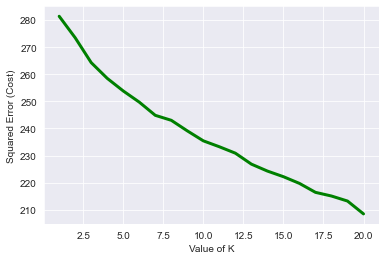

In [13]:
import matplotlib.pyplot as plt

def elbow_test(data, max_k=5, max_iter=500):
    # perform elbow test
    cost =[]
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, max_iter=max_iter)
        kmeans.fit(data)

        # calculates squared error
        # for the clustered points
        cost.append(kmeans.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, max_k), cost, color ='g', linewidth ='3')
    #plt.title("Elbow test for clustering with Title as input")
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot

elbow_test(X, max_k=21)

# PCA & KMeans

In [14]:
def make_pca_vecs(data, n_clusters=5):
# vary here the number of clusters
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(data)
    clusters = kmeans.labels_
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(data.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return clusters, clusters, x0, x1

In [15]:
# assign clusters and pca vectors to our dataframe 
clusters_df, df['cluster'], df['x0'], df['x1'] = make_pca_vecs(X, n_clusters=3)

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [17]:
def get_top_keywords(this_df, data, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(df, X, clusters_df, 10)



Cluster 1
predict,across,stereotyp,annot,often,process,context,reduc,machin,state

Cluster 2
featur,includ,fine,english,challeng,classif,framework,news,analyz,demograph

Cluster 3
investig,identifi,stereotyp,framework,techniqu,score,may,domain,larg,translat


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               3: "cluster 04", 
               4: "cluster 05", 
               5: "cluster 06", 
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

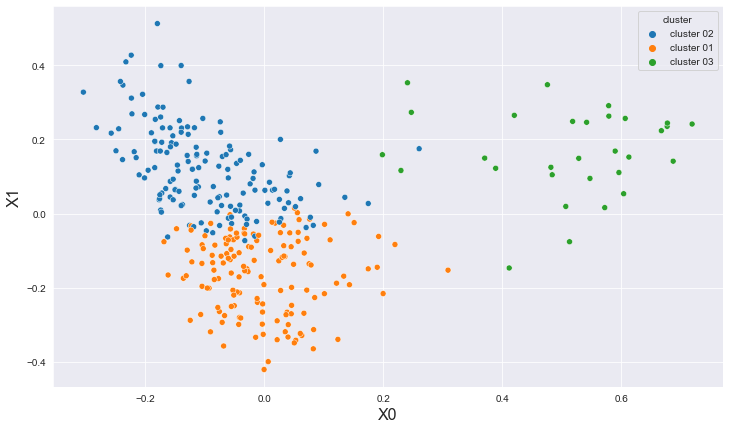

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

def make_kmeans_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    #plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='cluster')
    plt.show()
    
make_kmeans_plot(df)

# stats & plots

## ngram analysis

In [20]:
from nltk.util import ngrams
from collections import Counter

def count_ngrams(this_df, num, keyword_list, pos):
    
    all_ngrams = []
    bias_ngrams = []
    
    for idx, row in this_df.iterrows():
        tokens = nltk.word_tokenize(row['cleaned_w_title'])
        ngrams = set(nltk.ngrams(tokens, num))
        all_ngrams += ngrams
        
    frequence = Counter(all_ngrams)

    for entry, value in frequence.most_common():
        if entry[pos] in keyword_list:
            bias_ngrams.append((entry, value))
    
    if bias_ngrams:
        return bias_ngrams
    return frequence.most_common()


print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df, 2, [''], 0)[:30])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, [''], 0)[:40])
print()
print('POSITION 0')
print('BIGRAMS')
print(count_ngrams(df, 2, ['bia', 'bias'], 0)[:20])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bia', 'bias'], 0)[:40])
print('BIGRAMS')
print()
print('POSITION 1')
print(count_ngrams(df, 2, ['bia', 'bias'], 1)[:50])
print()
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bia', 'bias'], 1)[:40])
print()
print('POSITION 2')
print('TRIGRAMS')
print(count_ngrams(df, 3, ['bia', 'bias'], 2)[:40])

MOST COMMON
BIGRAMS
[(('gender', 'bia'), 91), (('natur', 'languag'), 67), (('word', 'embed'), 64), (('languag', 'model'), 55), (('e', 'g'), 44), (('languag', 'process'), 41), (('state', 'art'), 37), (('train', 'data'), 37), (('social', 'bia'), 35), (('mitig', 'bia'), 32), (('machin', 'learn'), 31), (('model', 'train'), 30), (('pre', 'train'), 28), (('bia', 'word'), 27), (('debias', 'method'), 27), (('machin', 'translat'), 24), (('real', 'world'), 23), (('fine', 'tune'), 21), (('paper', 'propos'), 21), (('nlp', 'system'), 17), (('propos', 'method'), 17), (('test', 'set'), 16), (('wide', 'use'), 16), (('social', 'medium'), 16), (('process', 'nlp'), 15), (('downstream', 'task'), 15), (('et', 'al'), 15), (('bia', 'mitig'), 15), (('experi', 'show'), 15), (('mitig', 'gender'), 15)]

TRIGRAMS
[(('natur', 'languag', 'process'), 40), (('bia', 'word', 'embed'), 22), (('languag', 'process', 'nlp'), 15), (('pretrain', 'languag', 'model'), 14), (('mitig', 'gender', 'bia'), 14), (('reduc', 'gender',

## type of bias plot

In [21]:
def issublist(org, sub):
    return any(org[idx : idx + len(sub)] == sub for idx in range(len(org) - len(sub) + 1))

In [22]:
def find_paper(keyword, text):
    
    if keyword in text:
        
        if keyword == 'social':
            if issublist(text, [keyword,'medium']) and not issublist(text, [keyword,'bia']):
                return False
        
        if keyword in ['annot', 'evalu', 'inher', 'predict', 'label', 'represent', 'societ', 'stereotyp']:
            if not (issublist(text, ['bia', keyword]) or issublist(text, [keyword, 'bia'])):
                return False
            
        if keyword == 'african' and not issublist(text, ['against','african']):
            return False
        
        return True
        
    return False

In [23]:
ps = PorterStemmer()
print(ps.stem('inherent'))

inher


In [24]:
# hand crafted bias list (feel free to change)
### TODO 'ableist', 'diachron' did not work for conferences
bias_list = ['aae', 'ableist', 'african', 'age', 'annot','demograph', 'diachron', 'disabl', 'ethnic', 'ethnograph', 'evalu', 'frame', 
             'gender', 'implicit', 'inher', 'label', 'predict', 'race', 'racial', 'religi', 'represent', 'sampl', 'select', 'semant', 
             'sens', 'social', 'societ', 'stereotyp']

bias_label_list = ['Age', 'Ableist', 'Annotator', 'Demographic', 'Diachronic', 'Evaluation', 'Framing', 'Gender', 'Label', 'Prediction',
             'Racial', 'Religious', 'Selection', 'Semantic', 'Common Sense', 'Social', 'Societal', 'Stereotype']

# ONE HOT ENCODING
def one_hot(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df[i] = this_df['cleaned_w_title'].str.split().apply(lambda x: find_paper(i, x))
    this_df['racial'] += this_df['race'] + this_df['ethnic'] + this_df['aae'] + this_df['african'] + this_df['ethnograph']
    this_df['select'] += this_df['sampl'] + this_df['represent']
    this_df['semant'] += this_df['implicit'] + this_df['inher']
    this_df['ableist'] += this_df['disabl']
        
def add_not_spec_col(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df.loc[(this_df[i] == True), 'not_specified'] = False
        
    this_df.loc[(this_df['not_specified'].isnull()), 'not_specified'] = True
        
one_hot(df)
add_not_spec_col(df)

In [25]:
bias_list.remove('race')
bias_list.remove('ethnic')
bias_list.remove('sampl')
bias_list.remove('aae')
bias_list.remove('african')
bias_list.remove('implicit')
bias_list.remove('represent')
bias_list.remove('disabl')
bias_list.remove('ethnograph')
bias_list.remove('inher')

In [26]:
def count_biases(this_df, bias_list=bias_list):
    counts = []
    for i in bias_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['not_specified'].value_counts())
    
    return counts

ableist
age
annot
demograph
diachron
evalu
frame
gender
label
predict
racial
religi
select
semant
sens
social
societ
stereotyp
ableist           0
age               4
annot             1
demograph        11
diachron          1
evalu             5
frame             1
gender           35
label             0
predict           0
racial           12
religi            1
select            7
semant           12
sens              1
societ            1
stereotyp         6
not_specified     0
Name: True, dtype: int64


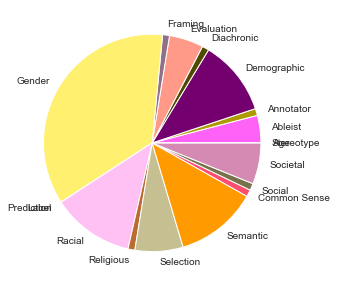

In [27]:
def count_social_biases(this_df, bias_list=bias_list):
    counts = []
    temp_df = pd.DataFrame()
    for i in bias_list:
        print(i)
        if i == 'social':
            continue
        temp_df[i] = pd.crosstab(this_df[i],this_df['social']).loc[True]
        
    temp_df['not_specified'] = (this_df['social'].value_counts() - temp_df.sum(axis=True)).clip(0, None)
    
    plt.pie(temp_df.loc[True], labels = bias_label_list, colors = colors)
    #plt.title('Bias type in papers mentioning "social bias"')
        
    return temp_df.loc[True]

print(count_social_biases(df, bias_list=bias_list))

               False  True
ableist          318     2
age              305    15
annot            308    12
demograph        278    42
diachron         316     4
evalu            302    18
frame            315     5
gender           173   147
label            317     3
predict          317     3
racial           269    51
religi           314     6
select           273    47
semant           274    46
sens             315     5
social           254    66
societ           306    14
stereotyp        302    18
not_specified    255    65


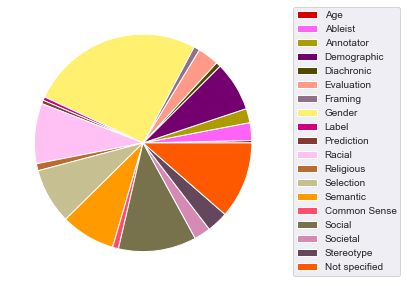

In [28]:
def plot_counts(this_df):
    df_counts = pd.concat(count_biases(this_df), axis=1).transpose().fillna(0)
    print(df_counts)
    plt.pie(df_counts[True], colors = colors)
    pylab.ylabel('')
    plt.legend(bias_label_list + ['Not specified'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
plot_counts(df)

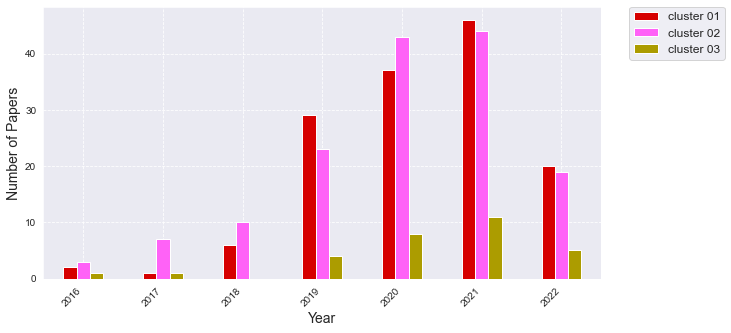

In [29]:
# year per cluster
def year_per_clust_plot(this_df):
    pd.crosstab(this_df['year'],this_df['cluster']).plot(kind='bar', color=colors);
    #plt.title('Paper per year by cluster', fontdict={"fontsize": 10})
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.grid(linestyle='--')
    
year_per_clust_plot(df)

In [30]:
bias_label_wo_social = bias_label_list.copy()
bias_label_wo_social.remove('Social')
bias_label_wo_social.remove('Ableist')
bias_label_wo_social.remove('Label')
bias_label_wo_social.remove('Prediction')

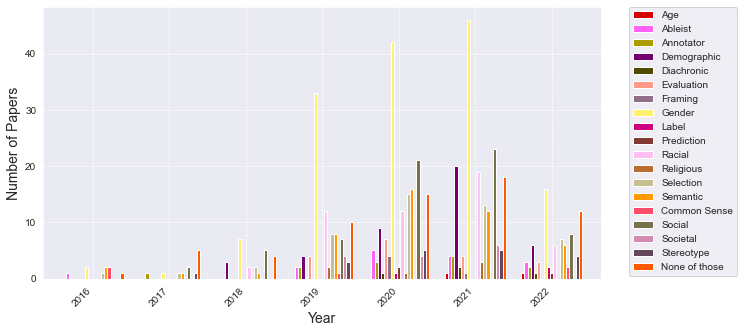

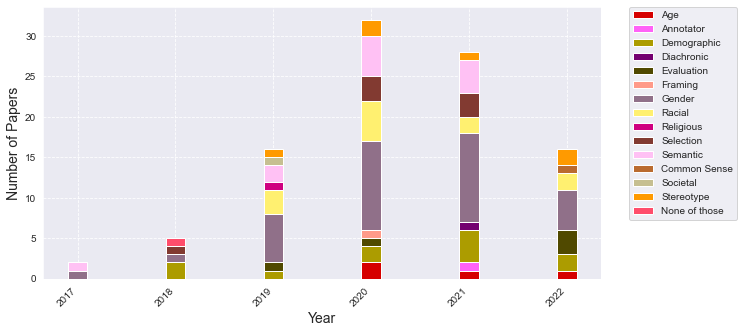

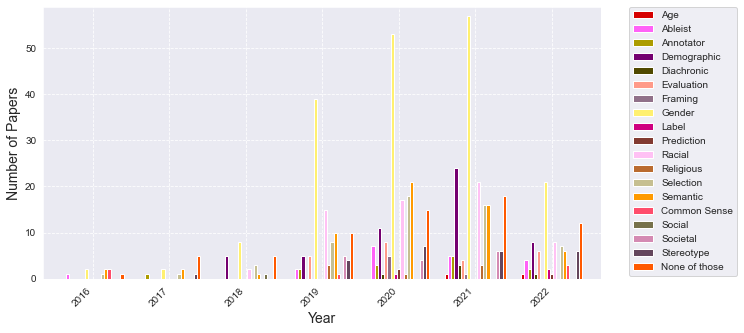

In [31]:
# bias per year
def bias_per_year_plot(this_df, this_bias_list=bias_list):
    
    temp_df = pd.DataFrame()
    social_df = pd.DataFrame()
    this_social_df = this_df.loc[this_df['social'] == True]
    this_bias_label_list = bias_label_list.copy()
    count_dels = 0
    
    for idx, val in enumerate(this_bias_list):
        
        if this_df[val].any():
            temp_df[val] = pd.crosstab(this_df[val],this_df['year']).loc[True]
        else:
            del this_bias_label_list[idx-count_dels]
            count_dels += 1
        
        if val == 'social':
            continue
        
        if this_social_df[val].any():
            social_df[val] = pd.crosstab(this_social_df[val],this_social_df['year']).loc[True]
    
    social_df['undefined'] = (temp_df['social'] - social_df[(social_df != 0)].sum(axis=1)).clip(0, None)
    social_df['undefined'] = social_df['undefined'].astype('Int64')
    social_df = social_df.fillna(0)
    social_splitted_df = temp_df.copy()
            
    temp_df['undefined'] = pd.crosstab(this_df['not_specified'],this_df['year']).loc[True]
    #temp_df['not_specified'] = temp_df['undefined'].astype('Int64')
    social_splitted_df['undefined'] = pd.crosstab(this_df['not_specified'],this_df['year']).loc[True]
    
    social_splitted_df = social_splitted_df.add(social_df, fill_value=0)
    social_splitted_df['social'] = social_df['undefined']
    #social_splitted_df = social_splitted_df.drop('undefined',axis=1)
            
    temp_df.plot(kind='bar', stacked=False, width=0.8, color=colors);
    #plt.title('Paper per bias term by year')
    plt.legend(labels=this_bias_label_list + ['None of those'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    #plt.ylim(0,social_splitted_df['gender'].max()+2)
    plt.savefig("biastype_per_year.png", dpi=1200, bbox_inches='tight')
    plt.grid(linestyle='--')
    
    ### TODO: WRONG WITH DIFFERENT DATAFRAMES ###
    
    social_df.plot(kind='bar', stacked=True, width=0.2, color=colors);
    #plt.title('Paper mentioning "social" bias, splitted by subclass')
    plt.legend(labels=bias_label_wo_social + ['None of those'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(linestyle='--')
    
    social_splitted_df.plot(kind='bar', stacked=False, width=0.8, color=colors, figsize=(10,5));
    #plt.title('Paper per bias term by year, "social" bias splitted up in classes')
    plt.legend(labels=this_bias_label_list + ['None of those'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.savefig("biastype_per_year_social.png", dpi=1200, bbox_inches='tight')
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0,social_splitted_df['gender'].max()+2)
    plt.grid(linestyle='--')
    plt.show()
    
bias_per_year_plot(df)

In [32]:
# N-GRAM analysis of not specified bias

print('MOST COMMON')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 2, [''], 0)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 3, [''], 0)[:40])
print()
print('BIAS ON POSITION 1')
print('BIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 2, ['bias', 'biases'], 1)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['not_specified'] == True)], 3, ['bias', 'biases'], 1)[:40])
print()

MOST COMMON
BIGRAMS
[(('languag', 'model'), 13), (('state', 'art'), 12), (('natur', 'languag'), 12), (('improv', 'perform'), 9), (('train', 'data'), 7), (('machin', 'learn'), 6), (('e', 'g'), 6), (('recent', 'work'), 6), (('mitig', 'bia'), 5), (('propos', 'novel'), 5), (('languag', 'process'), 5), (('experi', 'show'), 5), (('name', 'entiti'), 5), (('word', 'embed'), 5), (('debias', 'method'), 5), (('task', 'show'), 4), (('hate', 'speech'), 4), (('paper', 'investig'), 4), (('result', 'show'), 4), (('show', 'effect'), 4), (('base', 'predict'), 4), (('text', 'classif'), 4), (('bia', 'propos'), 4), (('pretrain', 'languag'), 4), (('data', 'augment'), 4), (('make', 'model'), 4), (('entiti', 'recognit'), 4), (('show', 'method'), 4), (('languag', 'understand'), 4), (('manual', 'annot'), 4), (('pre', 'train'), 4), (('model', 'train'), 4), (('sentiment', 'analysi'), 4), (('model', 'perform'), 4), (('paper', 'propos'), 4), (('model', 'robust'), 4), (('significantli', 'improv'), 4), (('base', 'app

In [33]:
# year and social bigrams

print('MOST COMMON')
print('BIGRAMS 2016')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2016)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2017')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2017)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2018')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2018)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2019')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2019)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2020')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2020)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2021')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2021)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2022')
print(count_ngrams(df.loc[(df['social'] == True) & (df['year'] == 2022)], 2, [''], 0)[:40])
print()

MOST COMMON
BIGRAMS 2016
[]

BIGRAMS 2017
[(('design', 'neural'), 1), (('user', 'prefer'), 1), (('base', 'respons'), 1), (('incorpor', 'linguist'), 1), (('respons', 'custom'), 1), (('custom', 'talk'), 1), (('convers', 'corpu'), 1), (('propos', 'architectur'), 1), (('gener', 'attach'), 1), (('attach', 'special'), 1), (('topic', 'etc'), 1), (('model', 'produc'), 1), (('sn', 'show'), 1), (('impact', 'linguist'), 1), (('group', 'linguist'), 1), (('show', 'propos'), 1), (('gener', 'human'), 1), (('chines', 'sn'), 1), (('dynam', 'control'), 1), (('decod', 'base'), 1), (('prefer', 'languag'), 1), (('nrg', 'model'), 1), (('glba', 'nrg'), 1), (('paper', 'propos'), 1), (('corpu', 'gener'), 1), (('awar', 'neural'), 1), (('architectur', 'outperform'), 1), (('propos', 'incorpor'), 1), (('present', 'experiment'), 1), (('neural', 'respons'), 1), (('sn', 'encod'), 1), (('dataset', 'chines'), 1), (('essenti', 'factor'), 1), (('servic', 'sn'), 1), (('improv', 'user'), 1), (('experiment', 'result'), 1), 

In [34]:
# TODO 
# look at gender bias within social bias

In [35]:
PorterStemmer().stem('Neutralizing')

'neutral'

## type of research plots

In [36]:
verb_list = {'analysis': ['ass', 'assess', 'analyze', 'measur', 'discov', 'quantifi', 'understand', 'exploit', 'explor', 'examin', 'evalu', 'detect', 'investigat', 'summar', 'observ', 'provid'],
             'debiasing': ['debias', 'demonstr', 'employ', 'introduc', 'investigate', 'mitigat', 'neutral', 'propose', 'reduc', 'remov', 'unbias']} # list of verbs to get insights about the type of research


In [37]:
df['analysis'] = False
df['debiasing'] = False

In [38]:
def find_verb(verb, text):
    
    if issublist(text, [verb]):
        return True
    
    return False

In [39]:
# ONE HOT ENCODING
def one_hot_verb(this_df, verb_list=verb_list):
    for key in verb_list.keys():
        for i in verb_list[key]:
            this_df[key] += this_df['cleaned_w_title'].str.split().apply(lambda x: find_verb(i, x))
                        
def add_not_spec_verb(this_df, verb_list=verb_list):
    for key in verb_list.keys():
        for i in verb_list[key]:
            this_df.loc[(this_df[key] == True), 'no_spec'] = False
        
    this_df.loc[(this_df['no_spec'].isnull()), 'no_spec'] = True

one_hot_verb(df)
add_not_spec_verb(df)

[True     255
False     65
Name: analysis, dtype: int64, True     189
False    131
Name: debiasing, dtype: int64, False    293
True      27
Name: no_spec, dtype: int64]


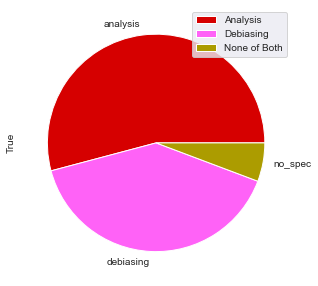

In [40]:
def plot_verb_count(this_df):
    counts = []
    for key in verb_list.keys():
        counts.append(this_df[key].value_counts())
    counts.append(this_df['no_spec'].value_counts())
        
    print(counts)
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot(kind='pie', y=True, figsize=(5, 5), colors=colors);
    plt.legend(labels=['Analysis', 'Debiasing', 'None of Both'])
    
plot_verb_count(df)

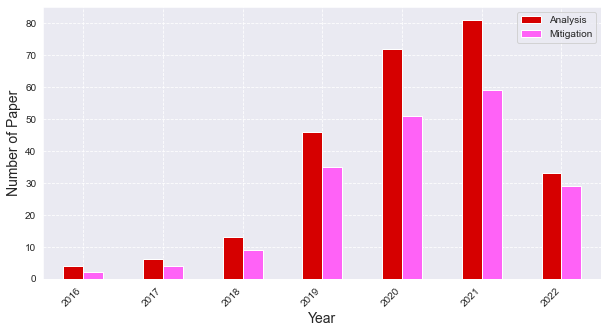

In [43]:
# bias per year
def researchtype_per_year_plot(this_df, bias_list=bias_list):
    
    temp_df = pd.DataFrame()
    
    temp_df['analysis'] = pd.crosstab(this_df['analysis'],this_df['year']).loc[True]
    temp_df['debiasing'] = pd.crosstab(this_df['debiasing'],this_df['year']).loc[True]
    #temp_df['no_spec'] = pd.crosstab(this_df['no_spec'],this_df['year']).loc[True]
            
    #temp_df['not_specified'] = pd.crosstab(this_df['not_specified'],this_df['year']).loc[True]
    #temp_df['not_specified'] = temp_df['not_specified'].astype('Int64')
    
    temp_df.plot(kind='bar', stacked=False, color=colors);
    #plt.title('Paper per research type by year')
    plt.legend(labels=['Analysis', 'Mitigation'])
    #, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of Paper")
    plt.grid(linestyle='--')
    plt.savefig("type_of_research.png", dpi=1200, bbox_inches='tight')
    plt.show()
    
researchtype_per_year_plot(df)

In [42]:
# BIGRAMS about no_spec column per year

print('MOST COMMON')
print('UNIGRAMS')
print(count_ngrams(df.loc[(df['no_spec'] == True)], 1, [''], 0)[:40])
print()
print('BIGRAMS')
print(count_ngrams(df.loc[(df['no_spec'] == True)], 2, [''], 0)[:40])
print()
print('TRIGRAMS')
print(count_ngrams(df.loc[(df['no_spec'] == True)], 3, [''], 0)[:40])
print()

print('BIGRAMS 2016')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2016)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2017')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2017)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2018')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2018)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2019')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2019)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2020')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2020)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2021')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2021)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2022')
print(count_ngrams(df.loc[(df['no_spec'] == True) & (df['year'] == 2022)], 2, [''], 0)[:40])
print()

MOST COMMON
UNIGRAMS
[(('bia',), 22), (('model',), 19), (('languag',), 15), (('paper',), 14), (('show',), 12), (('propos',), 12), (('train',), 12), (('gender',), 11), (('system',), 11), (('use',), 11), (('studi',), 10), (('data',), 9), (('task',), 9), (('gener',), 9), (('base',), 9), (('analysi',), 9), (('also',), 8), (('find',), 8), (('work',), 8), (('learn',), 8), (('type',), 7), (('method',), 7), (('bias',), 7), (('machin',), 7), (('word',), 7), (('mani',), 7), (('differ',), 7), (('nlp',), 7), (('e',), 7), (('repres',), 7), (('dataset',), 7), (('develop',), 7), (('improv',), 6), (('perform',), 6), (('exist',), 6), (('approach',), 6), (('design',), 6), (('howev',), 6), (('translat',), 6), (('represent',), 6)]

BIGRAMS
[(('gender', 'bia'), 7), (('machin', 'translat'), 6), (('neural', 'machin'), 5), (('e', 'g'), 5), (('gender', 'balanc'), 4), (('train', 'data'), 4), (('make', 'model'), 3), (('paper', 'analyz'), 3), (('bia', 'use'), 3), (('languag', 'model'), 3), (('paper', 'propos'), 3

## type of task plots

In [ ]:
PorterStemmer().stem('disambiguation')

In [ ]:
task_list = [['stereotyp', 'assess'], ['assess', 'bia'], ['speech','recognit'], ['languag', 'gener'], 
             ['machin','translat'], ['corefer','resolut'], ['role','label'],
             ['hate','speech', 'detect'], ['word','embed'], ['imag','caption'], ['question','answer'],
             ['name','entiti','recognit'], ['sentiment','analysi'], ['text', 'classif'], ['automat', 'detect'], 
             ['bia', 'detect'], ['gener', 'corpu'], ['text', 'gener'], ['event', 'understand'], ['sens', 'disambigu']]

task_label_list = ['Bias Assessment in Data', 'Speech Recognition', 'Language Generation', 'Machine Translation', 
                   'Coreference Resolution', 'Role Labeling',
             'Hate Speech Detection', 'Word Embedding', 'Multimodal Tasks', 'Question Answering',
             'Named Entity Recognition', 'Sentiment Analysis', 'Text Classification',
             'Corpus Generation', 'Word Sense Disambiguation']

general_list = ['evalu', 'dialogu', 'chatbot', 'summar', 'model']

general_label_list = ['Higher-level Evaluation', 'Dialogue/Chatbots', 
                      'Summarization', 'Other LLM Tasks']


In [ ]:
def find_task(task, text):
    
    if not isinstance(task, list):
        if task in text:
            return True
    
    if task == ['bia', 'reduc']:
        if (issublist(text, [task[1], task[0]]) or issublist(text, [task[0], task[1]])):
            return True
        return False
    
    if task == ['word','embed']:
        if issublist(text, [task[1]]):
            return True

    if issublist(text, task):
        return True
    
    return False

In [ ]:
# ONE HOT ENCODING
def one_hot_task(this_df, task_list=task_list):
    for i in task_list:
        df[i[1]] = df['cleaned_w_title'].str.split().apply(lambda x: find_task(i, x))
        df.loc[(df[i[1]] == True), 'no_task'] = False
        
    for i in df['manual'].unique():
        if not pd.isnull(i):
            if not ',' in i:
                idx = df.index[df['manual'] == i].tolist()
                df.loc[idx, i] = True 
            else:
                for j in i.split(', '):
                    idx = df.index[df['manual'] == i].tolist()
                    df.loc[idx, j] = True 
        
    this_df['assess'] += this_df['bia'] + this_df['detect']
    this_df = this_df.drop(['bia'], axis=1)
    this_df['entiti'] += this_df['understand']
    this_df = this_df.drop(['understand'], axis=1)
    
    idx = df.index[pd.isnull(df['no_task'].tolist())]
    df.loc[idx, 'no_task'] = True
                        
    for idx, row in df[(df['no_task'] == True)].iterrows():  
        
        for i in general_list[:-1]:
            
            if find_task(i, row['cleaned_w_title'].split()):
                
                df.loc[idx, 'no_task'] = False
                    
                if i == 'dialogu' or i == 'chatbot':
                    df.loc[idx, 'dialogu'] = True
                    
                else:
                    df.loc[idx, i] = True 
                                
    for idx, row in df[(df['no_task'] == True)].iterrows():      
        if find_task('model', row['cleaned_w_title'].split()):
            df.loc[idx, 'model'] = True
            df.loc[idx, 'no_task'] = False

one_hot_task(df)

In [ ]:
task_list.remove(['assess', 'bia'])
task_list.remove(['automat', 'detect'])
task_list.remove(['text', 'gener'])
task_list.remove(['bia', 'detect'])
task_list.remove(['event', 'understand'])
general_list.remove('chatbot')

In [ ]:
def plot_task_count(this_df):
    counts = []
    for i in task_list:
        counts.append(this_df[i[1]].value_counts())
        
    for i in general_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['no_task'].value_counts())
        
    print(counts)
    print(task_label_list+general_label_list+['None of those'])
        
    df_counts = pd.concat(counts, axis=1).transpose()
    df_counts.plot(kind='pie', y=True, figsize=(5, 5), colors=colors, labels=None);
    pylab.ylabel('')
    plt.legend(task_label_list+general_label_list+['None of those'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
plot_task_count(df)

In [ ]:
# bias per year
def task_per_year_plot(this_df, this_task_list=task_list):
    
    temp_df = pd.DataFrame()
    this_task_label_list = task_label_list.copy() + general_label_list.copy()
    count_dels = 0
    
    for idx, val in enumerate(this_task_list):
        if this_df[val[1]].any():
            temp_df[val[1]] = pd.crosstab(this_df[val[1]],this_df['year']).loc[True]
        else:
            del this_task_label_list[idx-count_dels]
            count_dels += 1
            
    for idx, val in enumerate(general_list):
        if this_df[val].any():
            temp_df[val] = pd.crosstab(this_df[val],this_df['year']).loc[True]
        else:
            del this_task_label_list[idx-count_dels]
            count_dels += 1   
            
    temp_df['not_specified'] = pd.crosstab(this_df['no_task'],this_df['year']).loc[True]    
    
    temp_df.plot(kind='bar', stacked=False, color=colors, width=0.7, figsize=(10,5));
    #plt.title('Paper per NLP task by year')
    plt.legend(labels=this_task_label_list+['None of those'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=9)
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(linestyle='--')
    plt.savefig("task_count.png", dpi=1200, bbox_inches='tight')
    plt.show()
    
    return this_task_label_list
    
over_general_task_label_list = task_per_year_plot(df)

In [ ]:
print('MOST COMMON')
print('BIGRAMS general')
print(count_ngrams(df.loc[(df['no_task'] == True)], 2, [''], 0)[:60])
print()
print('MOST COMMON')
print('BIGRAMS 2016')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2016)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2017')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2017)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2018')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2018)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2019')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2019)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2020')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2020)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2021')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2021)], 2, [''], 0)[:40])
print()
print('BIGRAMS 2022')
print(count_ngrams(df.loc[(df['no_task'] == True) & (df['year'] == 2022)], 2, [''], 0)[:40])
print()

In [ ]:
df.to_csv('bias_paper_edited.csv')

In [ ]:
workshop_list = ['Workshop on Gender Bias in Natural Language Processing', 
                    'Workshop on Language Technology for Equality, Diversity and Inclusion',
                    'Workshop on Trustworthy Natural Language Processing', 
                    'Workshop on Ethics in Natural Language Processing',
                    'Workshop on Innovative Use of NLP for Building Educational Applications', 
                    'Workshop on Resources and Techniques for User and Author Profiling in Abusive Language',
                    "Workshop on Computational Modeling of People{'}s Opinions, Personality, and Emotions in Social Media",
                    'Workshop on New Frontiers in Summarization', 
                    'Workshop on Insights from Negative Results in NLP',
                    'Workshop on Abusive Language Online', 
                    'Widening Natural Language Processing Workshop',
                    'Workshop on Computational Linguistics for Cultural Heritage, Social Sciences, Humanities and Literature', 
                    'Workshop of the Australasian Language Technology Association', 
                    'Workshop on Noisy User-generated Text',
                    'Workshop on Computational Linguistics and Clinical Psychology: Improving Access',
                    'Workshop on Figurative Language Processing', 
                    'Workshop on Online Abuse and Harms',
                    'Workshop on Natural Language Processing and Computational Social Science', 
                    'Workshop on Causal Inference and NLP', 
                    'Workshop on Bridging Human{--}Computer Interaction and Natural Language Processing', 
                    'Joint Workshop on Narrative Understanding, Storylines, and Events', 
                    'Workshop on {NLP} for Similar Languages, Varieties and Dialects', 
                    'Workshop on the Use of Computational Methods in the Study of Endangered Languages',
                    'Arabic Natural Language Processing Workshop', 
                    'Workshop on Computational Approaches to Subjectivity, Sentiment and Social Media Analysis',
                    'International Workshop on Natural Language Processing for Social Media',
                    'Workshop on {C}hinese Language Processing'
                    'Workshop on Cognitive Modeling and Computational Linguistics',
                    'Workshop on Argument Mining',
                    'Workshop on NLP for Conversational AI',
                    'Workshop on Computational Approaches to Historical Language Change',
                    'Workshop on NLP for Internet Freedom: Censorship, Disinformation, and Propaganda',
                    'Clinical Natural Language Processing Workshop',
                    'Workshop on Deep Learning Approaches for Low-Resource NLP',
                    'Workshop on Widening NLP',
                    'Student Research Workshop',
                    'Natural Language Processing meets Journalism',
                    'Workshop on Evaluating NLG Evaluation',
                    'Workshop on Benchmarking',
                    'Workshop on Computational Approaches to Historical Language Change',
                    'Workshop on Biomedical Language Processing',
                    'Workshop on e-Commerce and NLP',
                    'Workshop for NLP Open Source Software',
                    'Workshop on Challenges {\&} Perspectives in Creating Large Language Models',
                    'Workshop on Speech and Language Processing for Assistive Technologies',
                    'Workshop on Interactive Natural Language Technology for Explainable Artificial Intelligence']
    
conference_list = ['Conferences of the Association for Machine Translation in the Americas',
                      'ACL', 'EMNLP', 'Language Resources and Evaluation Conference', 
                      'International Conference on Natural Language Generation', 
                      'Conference of the {E}uropean Chapter of the Association for Computational Linguistics',
                      'Conference of the European Chapter of the Association for Computational Linguistics',
                      'Conference of the Asia-Pacific Chapter of the Association for Computational Linguistics',
                      'Conference on Empirical Methods in Natural Language Processing',
                      'North {A}merican Chapter of the Association for Computational Linguistics',
                      'Conference of the North American Chapter of the Association for Computational Linguistics',
                      'Nordic Conference on Computational Linguistics',
                      'Annual Conference of the European Association for Machine Translation',
                      'CoNLL', 'Conference on Computational Natural Language Learning',
                      'International Conference on Computational Linguistics',
                      'Annual Meeting of the Association for Computational Linguistics',
                      'International Joint Conference on Natural Language Processing',
                      'Joint Conference on Lexical and Computational Semantics',
                      'Conference on Machine Translation',
                      'International Conference on Recent Advances in Natural Language Processing',
                      'Joint Conference on Lexical and Computational Semantics',
                      'International Conference on Language Resources and Evaluation',
                      'International Conference on Computational Linguistics']
    
others_list = ['Linguistic Issues in Language Technology', 
               'Annual Meeting of the Special Interest Group on Discourse and Dialogue']

In [ ]:
# ONE HOT ENCODING
def one_hot_venue(this_df):
    
    this_df['booktitle'] = this_df['booktitle'].fillna('0')
    this_df['workshop'] = this_df['booktitle'].str.contains('|'.join(workshop_list))
    this_df['conference'] = this_df['booktitle'].str.contains('|'.join(conference_list))
    this_df['other'] = this_df['booktitle'].str.contains('|'.join(others_list))
    
one_hot_venue(df)

In [ ]:
venues = {}

for idx, title in df['booktitle'].items():
        
    for venue in workshop_list + conference_list + others_list:
        
        if title == '':
            continue
            
        if venue in title:
            if venue == 'ACL':
                venue = 'Annual Meeting of the Association for Computational Linguistics'
                
            if venue == 'EMNLP':
                venue = 'Conference on Empirical Methods in Natural Language Processing' 
                
            if venue == 'Conference of the {E}uropean Chapter of the Association for Computational Linguistics':
                venue = 'Conference of the European Chapter of the Association for Computational Linguistics'
                
            if venue == 'CoNLL':
                venue = 'Conference on Computational Natural Language Learning'
                
            if venue == 'North {A}merican Chapter of the Association for Computational Linguistics':
                venue = 'Conference of the North American Chapter of the Association for Computational Linguistics'
                
            if venue == 'International Conference on Language Resources and Evaluation':
                venue = 'Language Resources and Evaluation Conference'
                
            if venue == 'Widening Natural Language Processing Workshop':
                venue = 'Workshop on Widening NLP'
            
            if venue in venues.keys():
                venues[venue] += 1
            else:
                venues[venue] = 1
        

In [ ]:
d_descending = sorted(venues.items(), key=lambda kv: kv[1], reverse=True)
counter = 1
for item in d_descending:
    print(str(counter) + '. ' + str(item[0]) + ' & ' + str(item[1]) + '\\\\')
    counter += 1
pprint.PrettyPrinter(indent=4).pprint(d_descending)

In [ ]:
# bias per year
def venue_per_year_plot(this_df, task_list=task_list):
    
    temp_df = pd.DataFrame()
    temp_df['Workshop'] = pd.crosstab(this_df['workshop'],this_df['year']).loc[True]
    temp_df['Conference'] = pd.crosstab(this_df['conference'],this_df['year']).loc[True]
    #temp_df['Other'] = pd.crosstab(this_df['other'],this_df['year']).loc[True]
        
    #temp_df['not_specified'] = pd.crosstab(this_df['not_specified'],this_df['year']).loc[True]
    #temp_df['not_specified'] = temp_df['not_specified'].astype('Int64')
    
    temp_df.plot(kind='bar', stacked=False, color=colors);
    #plt.title('Paper per venue type by year')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
    plt.ylabel("Number of Papers", fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(linestyle='--')
    plt.savefig("workshop_conference.png", dpi=1200, bbox_inches='tight')
    plt.show()
    
    
venue_per_year_plot(df)

# tasks and bias types

## get citations

In [ ]:
import string
def filter_symbols(in_string):
    translation_table = str.maketrans('', '', string.punctuation)
    out_string = in_string.translate(translation_table)
    return out_string

In [ ]:
def get_first_author(this_df):
    this_df['author'] = this_df['author'].str.strip('{}')
    this_df['first_author'] = this_df['author'].str.split(pat=' and').str[0]
    this_df['first_author'] = this_df['first_author'].str.removesuffix(' ')
    this_df['first_author'] = this_df['first_author'].apply(lambda x: filter_symbols(x))
    this_df['first_author'] = this_df['first_author'].str.split(pat=' ').str[::]
    
get_first_author(df)

In [ ]:
# from https://github.com/ckreibich/scholar.py
year_str = ''.join(str(df['year'][0]))
author_str = ' '.join(df['first_author'][0]).lower()
title_str = filter_symbols(df['title'][0].lower())
%run scholar.py -c 1 --author {author_str} -t -A {title_str} --after '2022' --txt


# Make and LDA

In [ ]:
### LDA with inspiration from here: https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13#:~:text=Topic%20modelling%20in%20natural%20language%20processing%20is%20a%20technique%20which,important%20to%20categories%20the%20documents.
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(this_df, col, range_min=1, range_max=3, mindf=0.01, maxdf=0.5):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    vectorizer = CountVectorizer(ngram_range=(range_min, range_max), min_df=mindf, max_df=maxdf)
    Z = vectorizer.fit_transform(this_df[col])
    new_df = pd.DataFrame(Z.toarray(), columns = vectorizer.get_feature_names())
    
    return Z, new_df, vectorizer

Z_df, _, cv_df = get_bow(df, 'cleaned_w_title')


In [ ]:
#print(Z_df)

In [ ]:
# Use LDA to look for 6 topics
from sklearn.decomposition import LatentDirichletAllocation

def make_lda(this_df, Z, vectorizer, n_topics=6, n_words=20):
    model_lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    model_lda.fit(Z)

    feature_names = vectorizer.get_feature_names()

    topic_list = []
    for topic_idx, topic in enumerate(model_lda.components_):
        top_n = [feature_names[i]
                  for i in topic.argsort()
                   [-n_words:]][::-1]

        top_features = ' '.join(top_n)

        topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

        print(f"Topic {topic_idx}:\n{top_features}")
        print('\n')

    topic_result = model_lda.transform(Z)
    this_df['topic']  = topic_result.argmax(axis=1)
    
make_lda(df, Z_df, cv_df, n_topics=3)

In [ ]:
def make_lda_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    #plt.title("LDA clustering on abstracts + title", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='topic')
    plt.show()
    
make_lda_plot(df)

In [ ]:
# topic per bias
def topic_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['topic']).loc[True]

    temp_df.transpose().plot(kind='bar', color=colors);
    #plt.title('Paper per bias term by topic')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

topic_per_bias_plot(df)

In [ ]:
# year per topic
def year_per_topic_plot(this_df):
    pd.crosstab(this_df['year'],this_df['topic']).plot(kind='bar', color=colors);
    #plt.title('Paper per year by topic', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_topic_plot(df)

In [ ]:
# TODO
# how do cluster correspond to topic
df_ws = df[df['booktitle'].str.contains('Workshop', na=False)]
df_ws.to_csv('ws_bias_paper.csv')
df_co = df[df['booktitle'].str.contains('Conference', na=False)]
df_co.to_csv('co_bias_paper.csv')

def main(this_df, data, n_cluster=6, max_words=20, bias_list=bias_list, run_stats=True):
    # length of dataframe
    print(f'entries: {len(this_df.index)}')
    
    # create cluster & pca components & print keywords for cluster
    cluster, this_df['cluster'], this_df['x0'], this_df['x1'] = make_pca_vecs(data, n_cluster)
    get_top_keywords(this_df, data, cluster, max_words)
    this_df['cluster'] = this_df['cluster'].map(cluster_map)
    
    # create kmeans plot
    make_kmeans_plot(this_df)
    #elbow_test(data)
    
    # do one hot encoding & create stats plots
    if run_stats:
        one_hot(this_df)
        bias_per_year_plot(this_df, bias_list)
        
        one_hot_verb(this_df)
        add_not_spec_verb(this_df)
        researchtype_per_year_plot(this_df, verb_list)
        
        one_hot_task(this_df)
        task_per_year_plot(this_df, task_list)
    
    year_per_clust_plot(this_df)
    
    # create lda vectorizer & perform LDA
    Z_df, _, cv_df = get_bow(this_df, 'cleaned_w_title')
    make_lda(this_df, Z_df, cv_df, n_topics=n_cluster)
    make_lda_plot(df)
    
    # stats of LDA
    if run_stats:
        topic_per_bias_plot(df)
        
    year_per_topic_plot(df)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# create vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)

In [ ]:
# ONLY LOOK AT WORKSHOP PAPERS
data1 = vectorizer.fit_transform(df_ws['cleaned_w_title'])
main(df_ws, data1, n_cluster=3)

In [ ]:
# ONLY LOOK AT CONFERENCE PAPERS
data2 = vectorizer.fit_transform(df_co['cleaned_w_title'])
main(df_co, data2, n_cluster=3)

In [ ]:
# ONLY LOOK AT PAPERS CONTAINING "SOCIAL"
df_social = df[df['abstract'].str.contains('social', na=False)]
data_social = vectorizer.fit_transform(df_social['cleaned_w_title'])
main(df_social, data_social, n_cluster=5, bias_list=bias_list)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 3 CLUSTER
df_unspec = df[df['not_specified'] == True]
data_unspec = vectorizer.fit_transform(df_unspec['cleaned_w_title'])
main(df_unspec, data_unspec, n_cluster=3, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 2 CLUSTER
main(df_unspec, data_unspec, n_cluster=2, run_stats = False)

In [ ]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 6 CLUSTER
main(df_unspec, data_unspec, n_cluster=6, run_stats = False)

In [ ]:
df.head()

In [ ]:
print(df.loc[idx, 'title'].split()[0].lower())

In [ ]:
research_list = ['Analysis', 'Debiasing']

In [ ]:
def get_biastype(idx):
    biastype = []
    for i, val in enumerate(bias_list):
        if df.loc[idx, val] == True:
            biastype.append(bias_label_list[i])
            
    if len(biastype) == 0:
        biastype.append('Not listed')
    
    return ', '.join(biastype)

def get_research_type(idx):
    researchtype = []
    for i, val in enumerate(research_list):
        if df.loc[idx, val.lower()] == True:
            researchtype.append(research_list[i])
            
    return ', '.join(researchtype)

def get_task_type(idx):
    tasktype = []
    for i, val in enumerate(task_list):
        if df.loc[idx, val[1]] == True:
            tasktype.append(over_general_task_label_list[i])
            
    len_task = len(task_list)
    for i, val in enumerate(general_list):
        if df.loc[idx, val] == True:
            tasktype.append(over_general_task_label_list[i+len_task])
             
    return ', '.join(tasktype)

In [ ]:
print(task_list)
print(general_list)
print(over_general_task_label_list)

In [ ]:
def print_paper_list(this_df):
    for idx in range(len(this_df)):
        name = this_df.loc[idx, 'first_author'][0].lower()
        title = this_df.loc[idx, 'title'].split()[0].lower()
        year = this_df.loc[idx, 'year']
        
        biastype = get_biastype(idx)
        researchtype = get_research_type(idx)
        tasktype = get_task_type(idx)
        
        line = f'\\citet{{{name}_{title}_{year}}} & {year} & {biastype} & {researchtype} & {tasktype} \\\\'
        print(line)

print_paper_list(df)

In [ ]:
print(df.iloc[272])